In [63]:
"""
Simulación del Modelo de Ising

Este notebook implementa una simulación de Monte Carlo del modelo de Ising en una red bidimensional de tamaño \(N \times N\), con cálculo de métricas como energía, magnetización, capacidad calorífica, susceptibilidad y tiempo de correlación integrado.

---

Parámetros de la simulación

- **N**: tamaño de la red (número de espines por dimensión).  
- **T**: temperatura del sistema.  
- **J**: constante de interacción entre espines.  
- **MC_STEPS**: número de pasos Monte Carlo.  
- **SAVE_INTERVAL**: intervalo de guardado de snapshots.  
- **SEED**: semilla para reproducibilidad.  

---

Instalación de dependencias

Para instalar las librerías necesarias en Jupyter, ejecute:

```bash
%pip install numpy numba tqdm scipy matplotlib imageio
"""

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
C:\Users\garci\AppData\Local\Temp\ipykernel_4636\2156581383.py:1: SyntaxWarning: invalid escape sequence '\('
  """


'\nSimulación del Modelo de Ising\n\nEste notebook implementa una simulación de Monte Carlo del modelo de Ising en una red bidimensional de tamaño \\(N \times N\\), con cálculo de métricas como energía, magnetización, capacidad calorífica, susceptibilidad y tiempo de correlación integrado.\n\n---\n\nParámetros de la simulación\n\n- **N**: tamaño de la red (número de espines por dimensión).  \n- **T**: temperatura del sistema.  \n- **J**: constante de interacción entre espines.  \n- **MC_STEPS**: número de pasos Monte Carlo.  \n- **SAVE_INTERVAL**: intervalo de guardado de snapshots.  \n- **SEED**: semilla para reproducibilidad.  \n\n---\n\nInstalación de dependencias\n\nPara instalar las librerías necesarias en Jupyter, ejecute:\n\n```bash\n%pip install numpy numba tqdm scipy matplotlib imageio\n'

In [55]:
# %% Cell 1: Imports, parseo de args, logging y perfilador
import os, sys, time
import logging
import cProfile
import pstats
import numba; from numba import njit, prange
import numpy as np
from tqdm import tqdm
import argparse
from scipy.signal import convolve2d
import io, imageio 
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger()

def parse_args():
    parser = argparse.ArgumentParser("Ising MC")
    parser.add_argument("-N", type=int, default=250)
    parser.add_argument("-T", type=float, default=1.0)
    parser.add_argument("-J", type=float, default=1.0)
    parser.add_argument("--steps",  type=int,   default=100, dest="MC_STEPS")
    parser.add_argument("--save-interval", type=int, default=1, dest="SAVE_INTERVAL")
    parser.add_argument("--seed", type=int, default=42)
    return parser.parse_args(args=[])

args = parse_args()


In [47]:
# %% Cell 2: Parámetros y semilla
N, T, J = args.N, args.T, args.J
MC_STEPS, SAVE_INTERVAL, SEED = args.MC_STEPS, args.SAVE_INTERVAL, args.seed

# Hilos y semilla
n_threads = max(1, int(os.cpu_count()*0.8))
numba.set_num_threads(n_threads)
print(f"Threads: {n_threads}/{os.cpu_count()}, seed={SEED}")

np.random.seed(SEED)


Threads: 12/16, seed=42


In [48]:
# %% Cell 3: Funciones de flip‐probs, mc_sweep y versiones vectorizadas
energy_changes = np.array([-8, -4, 0, 4, 8], np.int8)

def compute_flip_probs(T):
    return np.exp(-energy_changes.astype(np.float64) / T)

@njit(parallel=True, fastmath=True)
def mc_sweep(spins, N, w, rand_mat):
    accepted_per_i = np.zeros(N, np.int64)
    for i in prange(N):
        acc_i = 0
        for j in range(N):
            vecinos = (
                spins[(i + 1) % N, j] + spins[(i - 1) % N, j] +
                spins[i, (j + 1) % N] + spins[i, (j - 1) % N]
            )
            delta_E = 2 * spins[i, j] * vecinos
            idx     = delta_E // 4 + 2
            if delta_E <= 0 or rand_mat[i, j] < w[idx]:
                spins[i, j] = -spins[i, j]
                acc_i += 1
        accepted_per_i[i] = acc_i
    return spins, accepted_per_i.sum()

# Kernel de vecinos 4-conectividad
kernel = np.array([[0,1,0],
                   [1,0,1],
                   [0,1,0]], dtype=np.int8)

def compute_neighbor_sum(spins):
    return convolve2d(spins, kernel, mode='same', boundary='wrap')

def compute_energy_vec(spins, J):
    neigh = compute_neighbor_sum(spins)
    # Cada par contado dos veces, por eso /2
    return -J * np.sum(spins * neigh) / 2

def compute_magnetization_vec(spins):
    return spins.mean()


In [49]:
# %% Cell 4: Simulación principal (usando versiones vectorizadas para métricas)
# Inicialización
spins = np.random.choice(np.int8([-1, 1]), size=(N, N))
w     = compute_flip_probs(T)

# Prueba de compilación de mc_sweep
_ = mc_sweep(spins.copy(), N, w, np.random.rand(N, N))[0]

# Arrays
magnetizations   = np.zeros(MC_STEPS)
energies         = np.zeros(MC_STEPS)
acceptance_rates = np.zeros(MC_STEPS)
snapshots        = []

for step in tqdm(range(MC_STEPS), desc="MC sweeps"):
    rnd = np.random.rand(N, N)
    spins, acc = mc_sweep(spins, N, w, rnd)
    acceptance_rates[step] = acc / (N * N)
    # aquí usamos las funciones vectorizadas
    magnetizations[step]   = compute_magnetization_vec(spins)
    energies[step]         = compute_energy_vec(spins, J)
    if step % SAVE_INTERVAL == 0:
        snapshots.append(spins.copy())


MC sweeps: 100%|██████████| 100/100 [00:00<00:00, 272.08it/s]


In [50]:
# %% Cell 5: Post-procesado, DataFrame y guardado (sin HDF5)
import pandas as pd

# Cálculo de calor y susceptibilidad
mean_E, mean_E2    = energies.mean(), (energies**2).mean()
heat_capacity     = (mean_E2 - mean_E**2) / (T**2 * N**2)
mean_m, mean_m2    = magnetizations.mean(), (magnetizations**2).mean()
susceptibility    = N**2 * (mean_m2 - mean_m**2) / T

# Autocorrelación y τ_int
mag      = magnetizations - mean_m
acf_full = np.correlate(mag, mag, mode='full')
acf      = acf_full[MC_STEPS - 1:] / acf_full[MC_STEPS - 1]
tau_int  = 1 + 2 * np.sum(acf[1:])

# Crear DataFrame de métricas por paso
df = pd.DataFrame({
    'step': np.arange(MC_STEPS),
    'magnetization': magnetizations,
    'energy': energies,
    'acceptance': acceptance_rates
})
# Exportar métricas
df.to_csv('ising_metrics.csv', index=False)
df.to_pickle('ising_metrics.pkl')

# Guardado de snapshots y métricas finales
snap_arr = np.array(snapshots, dtype=np.int8)
np.savez_compressed(
    "ising_data.npz",
    snapshots=snap_arr,
    magnetization=magnetizations,
    energy=energies,
    acceptance=acceptance_rates,
    heat_capacity=heat_capacity,
    susceptibility=susceptibility,
    autocorrelation=acf,
    tau_int=tau_int
)

# Resumen final
elapsed = time.time() - start_time
h, rem = divmod(elapsed, 3600)
m, s   = divmod(rem, 60)
print(
    f"Simulación completada en {int(h):02d}:{int(m):02d}:{int(s):02d}\n"
    f"Heat capacity per spin:  {heat_capacity:.6f}\n"
    f"Susceptibility:          {susceptibility:.6f}\n"
    f"Integrated corr. time τ: {tau_int:.2f} pasos"
)


Simulación completada en 00:09:01
Heat capacity per spin:  1383.180280
Susceptibility:          8.411303
Integrated corr. time τ: 0.00 pasos


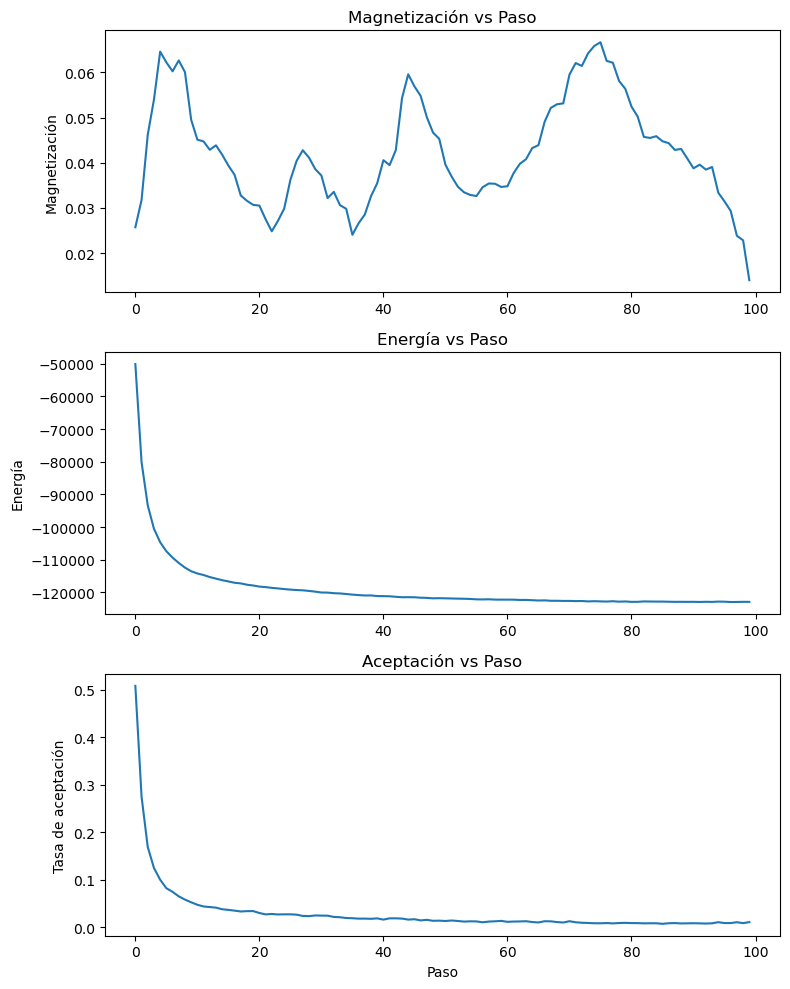

In [52]:
# %% Cell 6: Plot de métricas tras simulación
import matplotlib.pyplot as plt

# Eje de pasos
steps = np.arange(MC_STEPS)

# Crear figura con 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Magnetización vs paso
axs[0].plot(steps, magnetizations)
axs[0].set_ylabel('Magnetización')
axs[0].set_title('Magnetización vs Paso')

# Energía vs paso
axs[1].plot(steps, energies)
axs[1].set_ylabel('Energía')
axs[1].set_title('Energía vs Paso')

# Tasa de aceptación vs paso
axs[2].plot(steps, acceptance_rates)
axs[2].set_ylabel('Tasa de aceptación')
axs[2].set_xlabel('Paso')
axs[2].set_title('Aceptación vs Paso')

plt.tight_layout()
plt.show()


Usando 12 threads de 16 disponibles
Leyendo datos y preparando frames…


2025-05-06 23:29:54,749 INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2560x1920 -pix_fmt rgba -framerate 20.0 -loglevel error -i pipe: -vcodec libx264 -b 2000k -threads 12 -preset medium -crf 18 -pix_fmt yuv420p -y ising.mp4


Datos preparados en 00:00:00
Instanciando FuncAnimation (compilación)…
Animación lista en 00:00:00
Guardando animación en 'ising.mp4'…
Frame 100/100 (100.0%)  Elapsed 00:00:11  ETA 00:00:00
Guardado MP4 completado en 00:00:12
Guardando GIF en 'ising.gif'…
Guardado GIF completado en 00:00:00


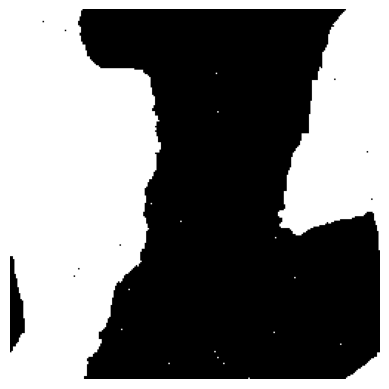

In [56]:
# %% Cell 7: Animación con MP4 y GIF opcional

# Parámetros
file_in      = "ising_data.dat"
file_out     = "ising"
interval     = 50     # ms entre fotogramas
save_to_file = True
save_gif     = True   # Nueva opción para GIF
dpi          = 400

# Control de threads (~80% CPU)
n_threads = max(1, int(os.cpu_count() * 0.8))
print(f"Usando {n_threads} threads de {os.cpu_count()} disponibles")

# 1) Lectura de datos y preparación de frames
print("Leyendo datos y preparando frames…")
t0 = time.time()
frames_data = []
with open(file_in, "r") as f:
    data_str = f.read()
for block in data_str.strip().split("\n\n"):
    frames_data.append(np.loadtxt(io.StringIO(block), delimiter=","))
tiempo_lectura = time.time() - t0
h, rem = divmod(tiempo_lectura, 3600)
m, s   = divmod(rem, 60)
print(f"Datos preparados en {int(h):02d}:{int(m):02d}:{int(s):02d}")

# Preparación de la figura
fig, ax = plt.subplots()
ax.axis("off")
im = ax.imshow(frames_data[0], cmap="binary", vmin=-1, vmax=1)

def update(frame_index):
    im.set_data(frames_data[frame_index])
    return (im,)

nframes = len(frames_data)

if nframes > 1:
    # Compilación de animación
    print("Instanciando FuncAnimation (compilación)…")
    t0 = time.time()
    animation = FuncAnimation(fig, update, frames=nframes, blit=True, interval=interval)
    tiempo_compil = time.time() - t0
    h, rem = divmod(tiempo_compil, 3600)
    m, s   = divmod(rem, 60)
    print(f"Animación lista en {int(h):02d}:{int(m):02d}:{int(s):02d}")

    if save_to_file:
        # Guardar MP4
        fps = 1000 / interval
        writer = FFMpegWriter(
            fps=fps,
            codec="libx264",
            bitrate=2000,
            extra_args=[
                "-threads", str(n_threads),
                "-preset", "medium",
                "-crf", "18",
                "-pix_fmt", "yuv420p"
            ]
        )
        print(f"Guardando animación en '{file_out}.mp4'…")
        start_time = time.time()
        with writer.saving(fig, f"{file_out}.mp4", dpi=dpi):
            for i in range(nframes):
                update(i)
                writer.grab_frame()
                elapsed = time.time() - start_time
                frac    = (i + 1) / nframes
                eta     = elapsed * (1 - frac) / frac if frac > 0 else 0
                h_e, rem_e     = divmod(elapsed, 3600)
                m_e, s_e       = divmod(rem_e, 60)
                h_eta, rem_eta = divmod(eta, 3600)
                m_eta, s_eta   = divmod(rem_eta, 60)
                print(
                    f"\rFrame {i+1}/{nframes} ({frac*100:5.1f}%)  "
                    f"Elapsed {int(h_e):02d}:{int(m_e):02d}:{int(s_e):02d}  "
                    f"ETA {int(h_eta):02d}:{int(m_eta):02d}:{int(s_eta):02d}",
                    end="", flush=True
                )
        total_time = time.time() - start_time
        h_t, rem_t = divmod(total_time, 3600)
        m_t, s_t   = divmod(rem_t, 60)
        print(f"\nGuardado MP4 completado en {int(h_t):02d}:{int(m_t):02d}:{int(s_t):02d}")

        # Guardar GIF opcional
        if save_gif:
            print(f"Guardando GIF en '{file_out}.gif'…")
            start_time = time.time()
            with imageio.get_writer(f"{file_out}.gif", mode='I', duration=interval/1000) as gif_writer:
                for frame in frames_data:
                    # Normalizar de [-1,1] a [0,255]
                    img = ((frame + 1) * 127.5).astype(np.uint8)
                    gif_writer.append_data(img)
            total_time = time.time() - start_time
            h_t, rem_t = divmod(total_time, 3600)
            m_t, s_t   = divmod(rem_t, 60)
            print(f"Guardado GIF completado en {int(h_t):02d}:{int(m_t):02d}:{int(s_t):02d}")

else:
    # Un único frame: guardar imagen estática
    print("Un único frame: guardando PDF…")
    start_time = time.time()
    fig.savefig(f"{file_out}.pdf", dpi=dpi)
    total_time = time.time() - start_time
    h, rem   = divmod(total_time, 3600)
    m, s     = divmod(rem, 60)
    print(f"Imagen guardada en {int(h):02d}:{int(m):02d}:{int(s):02d}")
